In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, f_regression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score

In [35]:
DATASET_KEYS = ("f0s0", "f0s1", "f1s0", "f1s1")
SAVED_DATAFRAME_BASE = Path("HW5")
data_path  = Path("data")
if data_path.is_dir():
  activities = list(data_path.iterdir())
  activities = list(d.name for d in activities)
  print(activities)

['idle', 'running', 'stairs', 'walking']


In [36]:
data_collections = []

for index, activity in enumerate(activities, start=1): # index?
    activity_path = Path(data_path) / activity
    csv_files = list(activity_path.glob('*.csv'))
    df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)
    df['activity'] = activity
    data_collections.append(df)

data = pd.concat(data_collections, ignore_index=True)
data

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,1.000776,4.616021,8.576031,idle
1,0.718261,4.209007,8.446744,idle
2,-0.909797,-0.282516,9.203311,idle
3,5.099650,0.148441,8.418014,idle
4,1.762132,-0.162806,9.251195,idle
...,...,...,...,...
193855,5.109226,-15.452178,-1.470040,walking
193856,6.373365,-11.741165,-8.226476,walking
193857,3.289633,-9.993398,-0.383072,walking
193858,-2.978387,-3.050213,1.273715,walking


In [37]:
X = data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]
y = data['activity']
y = pd.DataFrame(y, columns=['activity'])

In [38]:
# 1
display(data.info())
# 2
display(data.describe())
# 2
display(data.describe(exclude = float))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193860 entries, 0 to 193859
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   accelerometer_X  193860 non-null  float64
 1   accelerometer_Y  193860 non-null  float64
 2   accelerometer_Z  193860 non-null  float64
 3   activity         193860 non-null  object 
dtypes: float64(3), object(1)
memory usage: 5.9+ MB


None

,accelerometer_X,accelerometer_Y,accelerometer_Z
count,193860.000000,193860.000000,193860.000000
mean,1.923550,1.598343,1.804896
std,8.404867,12.474041,7.191590
min,-39.188293,-39.188293,-39.188293
25%,-2.494758,-8.327033,-2.494758
50%,0.248997,-0.009577,0.905008
75%,4.668694,8.671799,7.187394
max,39.188293,39.188293,39.188293


,activity
count,193860
unique,4
top,running
freq,102240


In [39]:
def calculate_mode(series):
    return series.mode().iloc[0]

grouped_data = data.groupby('activity').agg({
    'accelerometer_X': ['mean', 'median', 'min', 'max'],
    'accelerometer_Y': ['mean', 'median', 'min', 'max'],
    'accelerometer_Z': ['mean', 'median', 'min', 'max']
})

mode_data = data.groupby('activity').agg({
    'accelerometer_X': calculate_mode,
    'accelerometer_Y': calculate_mode,
    'accelerometer_Z': calculate_mode
})

agg_data = pd.concat([grouped_data, mode_data], axis = 1)
agg_data.rename(columns = {'accelerometer_X': ('accelerometer_X', 'mode'),
                          'accelerometer_Y': ('accelerometer_Y', 'mode'),
                          'accelerometer_Z': ('accelerometer_Z', 'mode')}, inplace = True)
agg_data

,"(accelerometer_X, mean)","(accelerometer_X, median)","(accelerometer_X, min)","(accelerometer_X, max)","(accelerometer_Y, mean)","(accelerometer_Y, median)","(accelerometer_Y, min)","(accelerometer_Y, max)","(accelerometer_Z, mean)","(accelerometer_Z, median)","(accelerometer_Z, min)","(accelerometer_Z, max)","(accelerometer_X, mode)","(accelerometer_Y, mode)","(accelerometer_Z, mode)"
activity,,,,,,,,,,,,,,,
idle,0.096767,0.234632,-10.448297,8.135497,2.225971,0.028730,-2.595315,9.916783,8.973247,9.749189,-0.296881,21.988348,0.263362,-0.014365,9.763555
running,5.045705,3.605668,-39.188293,39.188293,8.083135,7.967903,-39.188293,39.188293,1.387356,0.407014,-39.188293,39.188293,39.188293,39.188293,-2.753332
stairs,0.353135,0.483629,-11.238382,14.164097,-9.574353,-8.944737,-25.828648,4.994305,-1.841333,-1.589750,-38.086960,17.492037,0.991200,-9.251195,-6.210559
walking,-2.661943,-2.298433,-26.815060,20.575770,-9.703702,-9.974244,-39.188293,14.441825,-1.126623,-0.933739,-39.169140,38.426937,-1.944092,-12.703634,-0.742202


In [40]:
agg_data.columns = [
            ('accelerometer_X',   'mean'),
            ('accelerometer_X', 'median'),
            ('accelerometer_X',    'min'),
            ('accelerometer_X',    'max'),
            ('accelerometer_X',   'mode'),
            ('accelerometer_Y',   'mean'),
            ('accelerometer_Y', 'median'),
            ('accelerometer_Y',    'min'),
            ('accelerometer_Y',    'max'),
            ('accelerometer_Y',   'mode'),
            ('accelerometer_Z',   'mean'),
            ('accelerometer_Z', 'median'),
            ('accelerometer_Z',    'min'),
            ('accelerometer_Z',    'max'),
            ('accelerometer_Z',   'mode')
            ]
agg_data.columns = pd.MultiIndex.from_tuples(agg_data.columns)
agg_data

accelerometer_X                                            \
                    mean    median        min        max      mode   
activity                                                             
idle            0.096767  0.234632 -10.448297   8.135497  2.225971   
running         5.045705  3.605668 -39.188293  39.188293  8.083135   
stairs          0.353135  0.483629 -11.238382  14.164097 -9.574353   
walking        -2.661943 -2.298433 -26.815060  20.575770 -9.703702   

         accelerometer_Y                                            \
                    mean     median        min       max      mode   
activity                                                             
idle            0.028730  -2.595315   9.916783  8.973247  9.749189   
running         7.967903 -39.188293  39.188293  1.387356  0.407014   
stairs         -8.944737 -25.828648   4.994305 -1.841333 -1.589750   
walking        -9.974244 -39.188293  14.441825 -1.126623 -0.933739   

         accelerometer_Z                                             
                    mean     median        min        max      mode  
activity                                                             
idle           -0.296881  21.988348   0.263362  -0.014365  9.763555  
running       -39.188293  39.188293  39.188293  39.188293 -2.753332  
stairs        -38.086960  17.492037   0.991200  -9.251195 -6.210559  
walking       -39.169140  38.426937  -1.944092 -12.703634 -0.742202

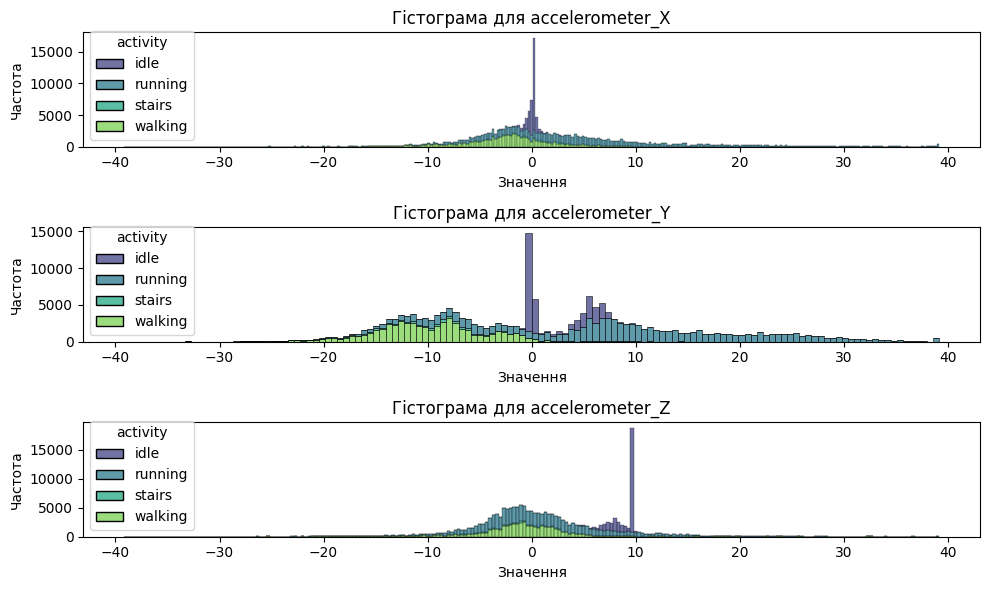

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6))

for idx, column in enumerate(['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']):
    sns.histplot(data=data, x=column, hue='activity', multiple='stack', palette='viridis', ax=axes[idx])
    axes[idx].set_title(f'Гістограма для {column}')
    axes[idx].set_xlabel('Значення')
    axes[idx].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [42]:
def mean(x):
    return x.mean()

def median(x): # Lecturer's comment
  return x.median()

def std(x):
    return x.std()

def max_value(x):
    return x.max()

def min_value(x):
    return x.min()

def rms(x):
    return np.sqrt((x ** 2).mean())

def peak_to_peak(x):
    return x.max() - x.min()

def autocorrelation(x):
    lag = 1
    corr = np.correlate(x, x[lag:], mode='full')[lag]
    return corr / x.std() ** 2

X_new = []
for signal in X[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']].to_numpy():
    features = [
        mean(signal),
        std(signal),
        max_value(signal),
        min_value(signal),
        rms(signal),
        peak_to_peak(signal),
        autocorrelation(signal)
    ]
    X_new.append(features)

X_new = pd.DataFrame(X_new, columns=['mean',
                                     'std',
                                     'max',
                                     'min',
                                     'rms',
                                     'peak_to_peak',
                                     'autocorrelation'
                                     ]
                     )
X_new

,mean,std,max,min,rms,peak_to_peak,autocorrelation
0,4.730943,3.093652,8.576031,1.000776,5.652655,7.575255,4.618974
1,4.458004,3.160049,8.446744,0.718261,5.464404,7.728483,3.863001
2,2.670333,4.626606,9.203311,-0.909797,5.341925,10.113108,-0.109460
3,4.555368,3.397905,8.418014,0.148441,5.683057,8.269573,0.173793
4,3.616840,4.060855,9.251195,-0.162806,5.438021,9.414001,-0.108731
...,...,...,...,...,...,...,...
193855,-3.937664,8.573592,5.109226,-15.452178,9.434600,20.561404,-0.765012
193856,-4.531425,7.843218,6.373365,-11.741165,9.058139,18.114530,0.353691
193857,-2.362279,5.600457,3.289633,-9.993398,6.078279,13.283031,-0.926074
193858,-1.584962,2.021602,1.273715,-3.050213,2.568848,4.323928,1.272271


In [44]:
X = pd.concat([X, X_new], axis=1)
X

,accelerometer_X,accelerometer_Y,accelerometer_Z,mean,std,max,min,rms,peak_to_peak,autocorrelation,mean,std,max,min,rms,peak_to_peak,autocorrelation
0,1.000776,4.616021,8.576031,4.730943,3.093652,8.576031,1.000776,5.652655,7.575255,4.618974,4.730943,3.093652,8.576031,1.000776,5.652655,7.575255,4.618974
1,0.718261,4.209007,8.446744,4.458004,3.160049,8.446744,0.718261,5.464404,7.728483,3.863001,4.458004,3.160049,8.446744,0.718261,5.464404,7.728483,3.863001
2,-0.909797,-0.282516,9.203311,2.670333,4.626606,9.203311,-0.909797,5.341925,10.113108,-0.109460,2.670333,4.626606,9.203311,-0.909797,5.341925,10.113108,-0.109460
3,5.099650,0.148441,8.418014,4.555368,3.397905,8.418014,0.148441,5.683057,8.269573,0.173793,4.555368,3.397905,8.418014,0.148441,5.683057,8.269573,0.173793
4,1.762132,-0.162806,9.251195,3.616840,4.060855,9.251195,-0.162806,5.438021,9.414001,-0.108731,3.616840,4.060855,9.251195,-0.162806,5.438021,9.414001,-0.108731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193855,5.109226,-15.452178,-1.470040,-3.937664,8.573592,5.109226,-15.452178,9.434600,20.561404,-0.765012,-3.937664,8.573592,5.109226,-15.452178,9.434600,20.561404,-0.765012
193856,6.373365,-11.741165,-8.226476,-4.531425,7.843218,6.373365,-11.741165,9.058139,18.114530,0.353691,-4.531425,7.843218,6.373365,-11.741165,9.058139,18.114530,0.353691
193857,3.289633,-9.993398,-0.383072,-2.362279,5.600457,3.289633,-9.993398,6.078279,13.283031,-0.926074,-2.362279,5.600457,3.289633,-9.993398,6.078279,13.283031,-0.926074
193858,-2.978387,-3.050213,1.273715,-1.584962,2.021602,1.273715,-3.050213,2.568848,4.323928,1.272271,-1.584962,2.021602,1.273715,-3.050213,2.568848,4.323928,1.272271


In [45]:
# EDA 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns.values.tolist())
X

,accelerometer_X,accelerometer_Y,accelerometer_Z,mean,std,max,min,rms,peak_to_peak,autocorrelation,mean,std,max,min,rms,peak_to_peak,autocorrelation
0,-0.109791,0.241917,0.941538,0.409004,-0.758117,0.036040,0.749028,-0.519328,-0.695994,-0.013729,0.409004,-0.758117,0.036040,0.749028,-0.519328,-0.695994,-0.013729
1,-0.143404,0.209288,0.923560,0.371231,-0.737260,0.021693,0.710776,-0.555897,-0.675514,-0.014366,0.371231,-0.737260,0.021693,0.710776,-0.555897,-0.675514,-0.014366
2,-0.337109,-0.150782,1.028762,0.123827,-0.276564,0.105650,0.490343,-0.579689,-0.356794,-0.017717,0.123827,-0.276564,0.105650,0.490343,-0.579689,-0.356794,-0.017717
3,0.377889,-0.116234,0.919565,0.384706,-0.662541,0.018504,0.633625,-0.513422,-0.603194,-0.017479,0.384706,-0.662541,0.018504,0.633625,-0.513422,-0.603194,-0.017479
4,-0.019205,-0.141185,1.035420,0.254818,-0.454286,0.110964,0.591483,-0.561022,-0.450234,-0.017717,0.254818,-0.454286,0.110964,0.591483,-0.561022,-0.450234,-0.017717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193855,0.379029,-1.366884,-0.455385,-0.790685,0.963320,-0.348677,-1.478641,0.215333,1.039684,-0.018270,-0.790685,0.963320,-0.348677,-1.478641,0.215333,1.039684,-0.018270
193856,0.529435,-1.069384,-1.394879,-0.872858,0.733884,-0.208393,-0.976183,0.142203,0.712644,-0.017327,-0.872858,0.733884,-0.208393,-0.976183,0.142203,0.712644,-0.017327
193857,0.162535,-0.929271,-0.304241,-0.572660,0.029356,-0.550600,-0.739542,-0.436649,0.066885,-0.018406,-0.572660,0.029356,-0.550600,-0.739542,-0.436649,0.066885,-0.018406
193858,-0.583227,-0.372659,-0.073862,-0.465083,-1.094885,-0.774309,0.200539,-1.118373,-1.130553,-0.016552,-0.465083,-1.094885,-0.774309,0.200539,-1.118373,-1.130553,-0.016552


<Axes: >

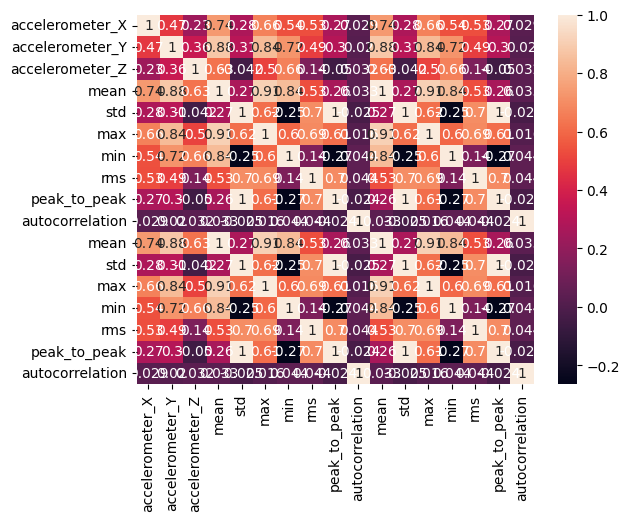

In [46]:
corr_x = X.corr()
sns.heatmap (corr_x, annot=True)

In [47]:
X = X.drop('peak_to_peak', axis=1)
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_new = labelencoder.fit_transform(y.values)
y_new

C:\Users\jyzhik\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, ..., 3, 3, 3])

In [52]:
pd.Series(y_new).value_counts()

1    102240
3     55500
0     31170
2      4950
Name: count, dtype: int64

In [54]:

f_stats, p_values = f_regression(X, y_new)
for i, (feature, f_stat, p_value) in enumerate(zip(range(X.shape[1]), f_stats, p_values)):
    print(f"Feature {i}: F-statistic={f_stat:.4f}, p-value={p_value:.4f}")

selected_features = np.where(p_values < 0.05)[0]
print("Selected Features:", selected_features)

Feature 0: F-statistic=14557.4291, p-value=0.0000
Feature 1: F-statistic=69912.7976, p-value=0.0000
Feature 2: F-statistic=32877.2356, p-value=0.0000
Feature 3: F-statistic=73786.5322, p-value=0.0000
Feature 4: F-statistic=591.0901, p-value=0.0000
Feature 5: F-statistic=55112.7509, p-value=0.0000
Feature 6: F-statistic=76026.5449, p-value=0.0000
Feature 7: F-statistic=139.1888, p-value=0.0000
Feature 8: F-statistic=0.0003, p-value=0.9872
Feature 9: F-statistic=73786.5322, p-value=0.0000
Feature 10: F-statistic=591.0901, p-value=0.0000
Feature 11: F-statistic=55112.7509, p-value=0.0000
Feature 12: F-statistic=76026.5449, p-value=0.0000
Feature 13: F-statistic=139.1888, p-value=0.0000
Feature 14: F-statistic=0.0003, p-value=0.9872
Selected Features: [ 0  1  2  3  4  5  6  7  9 10 11 12 13]


In [51]:
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

sfm = SelectFromModel(rf_model, prefit=True)
X_rf_selected = sfm.transform(X)

print("Original number of features:", X.shape[1])
print("Selected number of features:", X_rf_selected.shape[1])

C:\Users\jyzhik\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Original number of features: 15
Selected number of features: 7


C:\Users\jyzhik\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [55]:
X_rf_selected

array([[-0.10979068,  0.24191727,  0.94153759, ...,  0.03603986,
         0.40900429,  0.03603986],
       [-0.14340403,  0.20928831,  0.92356001, ...,  0.0216927 ,
         0.37123103,  0.0216927 ],
       [-0.33710872, -0.15078222,  1.02876191, ...,  0.10565005,
         0.12382679,  0.10565005],
       ...,
       [ 0.1625352 , -0.92927149, -0.30424059, ..., -0.55059951,
        -0.57266   , -0.55059951],
       [-0.58322746, -0.37265933, -0.0738616 , ..., -0.7743089 ,
        -0.4650834 , -0.7743089 ],
       [-0.74616716, -0.92389727, -0.47935531, ..., -1.09791692,
        -0.9799932 , -1.09791692]])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    )

X_rf_selected_train, X_rf_selected_test, y_train, y_test = train_test_split(X_rf_selected, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    )

SVM

In [58]:
svm_model = SVC(C=1.0,
                probability = True,
                tol = 0.0001,
                random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print('Classification report of SVM with time domain features:')
print(classification_report(y_test, y_pred_svm))

C:\Users\jyzhik\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Отчет о классификации SVM with time domain features:
              precision    recall  f1-score   support

        idle       0.96      0.98      0.97      6234
     running       0.93      0.91      0.92     20448
      stairs       1.00      0.00      0.01       990
     walking       0.81      0.90      0.85     11100

    accuracy                           0.90     38772
   macro avg       0.92      0.70      0.69     38772
weighted avg       0.90      0.90      0.88     38772



In [59]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_svm

array([[ 6115,    95,     0,    24],
       [  207, 18585,     0,  1656],
       [    5,   291,     3,   691],
       [   25,  1076,     0,  9999]], dtype=int64)

f-regression

In [60]:
svm_model = SVC(C=1.0,
                probability = True,
                tol = 0.0001,
                random_state=42)
svm_model.fit(X_rf_selected_train, y_train)

y_pred_svm_select = svm_model.predict(X_rf_selected_test)

print('Classification report of  SVM with time domain features (f-regression selection):')
print(classification_report(y_test, y_pred_svm_select))

C:\Users\jyzhik\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report of  SVM with time domain features (f-regression selection):
              precision    recall  f1-score   support

        idle       0.96      0.98      0.97      6234
     running       0.93      0.91      0.92     20448
      stairs       1.00      0.00      0.01       990
     walking       0.80      0.90      0.85     11100

    accuracy                           0.89     38772
   macro avg       0.92      0.70      0.69     38772
weighted avg       0.90      0.89      0.88     38772



In [61]:
conf_matrix_svm_select = confusion_matrix(y_test, y_pred_svm_select)
conf_matrix_svm_select

array([[ 6124,    93,     0,    17],
       [  194, 18531,     0,  1723],
       [    5,   295,     3,   687],
       [   29,  1111,     0,  9960]], dtype=int64)

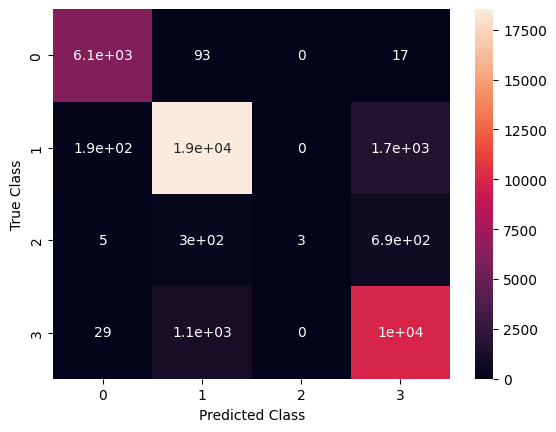

In [62]:
sns.heatmap(conf_matrix_svm_select, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

Random forest

In [63]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=3,
                                  random_state=42,
                                  )

rf_model.fit(X_train, y_train)

y_pred_rf_3 = rf_model.predict(X_test)

print('Отчет о классификации Random Forest:')
print(classification_report(y_test, y_pred_rf_3))

C:\Users\jyzhik\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Отчет о классификации Random Forest:


C:\Users\jyzhik\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jyzhik\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        idle       0.98      0.96      0.97      6234
     running       0.88      0.90      0.89     20448
      stairs       0.00      0.00      0.00       990
     walking       0.78      0.83      0.80     11100

    accuracy                           0.87     38772
   macro avg       0.66      0.67      0.67     38772
weighted avg       0.85      0.87      0.86     38772



C:\Users\jyzhik\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [64]:
conf_matrix_rf_3 = confusion_matrix(y_test, y_pred_rf_3)
conf_matrix_rf_3

array([[ 5995,   233,     0,     6],
       [  125, 18386,     0,  1937],
       [    2,   291,     0,   697],
       [   12,  1901,     0,  9187]], dtype=int64)

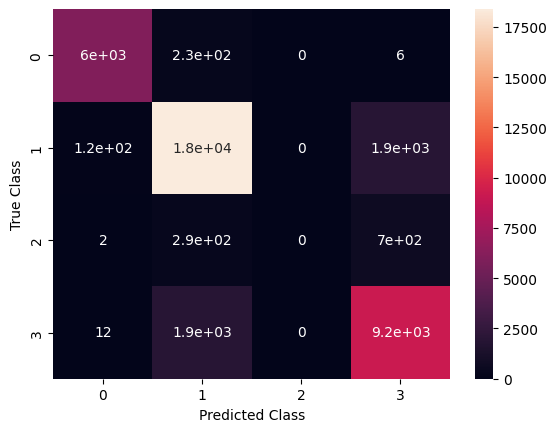

In [65]:
sns.heatmap(conf_matrix_rf_3, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

Random forest, depth= 15

In [66]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=15,
                                  random_state=42,
                                  )

rf_model.fit(X_train, y_train)

y_pred_rf_15 = rf_model.predict(X_test)

print('Отчет о классификации Random Forest:')
print(classification_report(y_test, y_pred_rf_15))

C:\Users\jyzhik\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Отчет о классификации Random Forest:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6234
     running       1.00      0.99      0.99     20448
      stairs       1.00      0.83      0.91       990
     walking       0.96      1.00      0.98     11100

    accuracy                           0.99     38772
   macro avg       0.99      0.95      0.97     38772
weighted avg       0.99      0.99      0.99     38772



In [67]:
conf_matrix_rf_15 = confusion_matrix(y_test, y_pred_rf_15)
conf_matrix_rf_15

array([[ 6228,     0,     0,     6],
       [   12, 20174,     0,   262],
       [    0,    14,   819,   157],
       [    1,     4,     0, 11095]], dtype=int64)

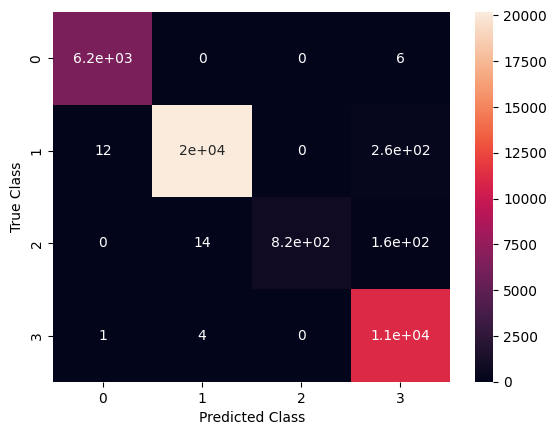

In [68]:
sns.heatmap(conf_matrix_rf_15, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

Features with select_from mode

In [69]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=15,
                                  random_state=42,
                                  )

rf_model.fit(X_rf_selected_train, y_train)

y_pred_rf_select = rf_model.predict(X_rf_selected_test)

print('Отчет о классификации Random Forest (SelectFromModel Features):')
print(classification_report(y_test, y_pred_rf_select))

C:\Users\jyzhik\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Отчет о классификации Random Forest (SelectFromModel Features):
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6234
     running       1.00      0.99      0.99     20448
      stairs       1.00      0.78      0.88       990
     walking       0.96      1.00      0.98     11100

    accuracy                           0.99     38772
   macro avg       0.99      0.94      0.96     38772
weighted avg       0.99      0.99      0.99     38772



In [70]:
conf_matrix_rf_select = confusion_matrix(y_test, y_pred_rf_select)
conf_matrix_rf_select

array([[ 6230,     4,     0,     0],
       [   12, 20143,     0,   293],
       [    2,    27,   776,   185],
       [    1,    10,     0, 11089]], dtype=int64)

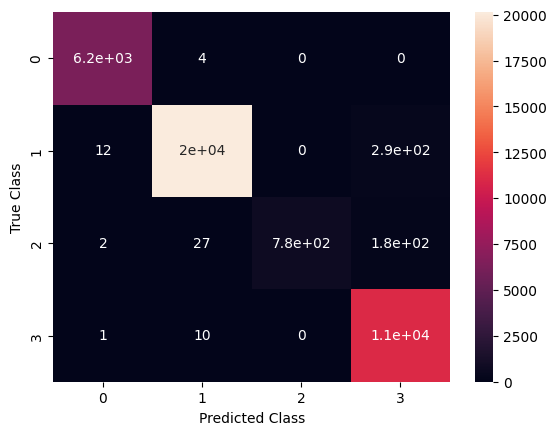

In [71]:
sns.heatmap(conf_matrix_rf_select, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()